In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import animation
import imageio
import os

In [2]:
# Code based on https://tomekkorbak.com/2019/10/08/lewis-signaling-games/
from tkinter import * 
from PIL import Image, ImageTk



In [3]:
class Sender:
        
    def __init__(self, n_inputs: int, n_messages: int, state_action_probs: np.ndarray = None, eps: float = 1e-6):
        self.n_messages = n_messages
        
        if state_action_probs is not None:
            self.action_weights = state_probs
        else:
            self.message_weights = np.zeros((n_inputs, n_messages))
            self.message_weights.fill(eps)
        
        self.last_situation = (0, 0)
        
    def send_message(self, input: int) -> int:
        #print(np.sum(np.exp(self.message_weights[input, :])))
        probs = np.exp(self.message_weights[input, :])/np.sum(np.exp(self.message_weights[input, :]))
        message = np.random.choice(self.n_messages, p=probs)
        self.last_situation = (input, message)
        return message
 

    def learn_from_feedback(self, reward: int) -> None:
        self.message_weights[self.last_situation] += reward

In [4]:
class Receiver:
        
    def __init__(self, n_messages: int, n_actions: int, state_action_probs = None, eps: float = 1e-6):
        self.n_actions = n_actions
        if state_action_probs is not None:
            self.action_weights = state_probs.T
        else:
            self.action_weights = np.ndarray((n_messages, n_actions))
            self.action_weights.fill(eps)
        self.last_situation = (0, 0)
        
    def act(self, message: int) -> int:
        try:
            probs = np.exp(self.action_weights[message, :])/np.sum(np.exp(self.action_weights[message, :]))
            action = np.random.choice(self.n_actions, p=probs)
            self.last_situation = (message, action)
        except:
            return None
        return action

    def learn_from_feedback(self, reward: int) -> None:
        self.action_weights[self.last_situation] += reward

In [5]:
class World:
    def __init__(self, n_states: int, n_messages: int, state_prob_distribution: np.ndarray = None, seed: int = 1701):
        self.n_states = n_states
        self.state = 0
        self.rng = np.random.RandomState(seed)
        self.signal_costs = np.ones(n_messages)
        self.signal_costs.fill(1)
        #self.signal_costs = [0.75, 0.1, 0.1, 0.05]
        
        self.state_probs = np.ones((n_states, n_messages))
        if state_prob_distribution is not None:
            self.state_probs = (self.state_probs.T * state_prob_distribution).T

        
    def emit_state(self) -> int:
        self.state = self.rng.randint(self.n_states)
        return self.state
    
    def evaluate_action(self, action: int) -> int:
        return 1 if action == self.state else -1
        #return self.signal_costs[action] if action == self.state else -self.signal_costs[action]

In [6]:
def train_signal(NUM_STATES : int, NUM_MESSAGES :int, STATE_PROBS : np.ndarray, epochs: np.ndarray ):
    """
    Update the sender and receiver weights based on the given parameters
    Return the sender and receiver objects
    """
    
    dir_path = '{}states_{}messages'.format(NUM_STATES, NUM_MESSAGES)
    
    try: 
        os.mkdir(dir_path) 
    except OSError as error: 
        pass  
    
    sender, receiver = Sender(NUM_STATES, NUM_MESSAGES), Receiver(NUM_MESSAGES, NUM_STATES)
    world = World(NUM_STATES, NUM_MESSAGES)
    past_rewards = 0
    matrices = []
    for epoch in range(epochs):

        world_state = world.emit_state()
        message = sender.send_message(world_state)

        action = receiver.act(message)
        reward = world.evaluate_action(action)
        receiver.learn_from_feedback(reward)
        sender.learn_from_feedback(reward)
        past_rewards += reward
        if epoch % 25 == 0:
            plt.tight_layout(pad=0)
            plot = sns.heatmap(
                (np.exp(receiver.action_weights.T)/np.exp(receiver.action_weights).sum(axis=1)).T, 
                square=True, cbar=False, annot=True, fmt='.2f'
            ).get_figure()
            plt.xlabel('actions')
            plt.ylabel('messages')
            plt.title(f'Receiver\'s weights, rollout {epoch}')
            plt.savefig(f"{dir_path}/receiver_{epoch}_n_by_m.png")
            plt.clf()

            plot = sns.heatmap(
                (np.exp(sender.message_weights.T)/np.exp(sender.message_weights).sum(axis=1)).T, 
                square=True, cbar=False,annot=True, fmt='.2f'
            ).get_figure()

            plt.xlabel('messages')
            plt.ylabel('world states')
            plt.title(f'Sender\'s weights, rollout {epoch}')
            plt.savefig(f"{dir_path}/sender_{epoch}_n_by_m.png")
            plt.clf()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, last 100 epochs reward: {past_rewards/100}')
            #print(world_state, message, action, reward)
            past_rewards = 0

    return sender, receiver

In [28]:
def get_game_trace(sender, receiver, num_states, num_messages):
    sender_softmax_rec = (np.exp(receiver.action_weights.T)/np.exp(receiver.action_weights).sum(axis=1)).T
    rec_softmax_rec = (np.exp(sender.message_weights.T)/np.exp(sender.message_weights).sum(axis=1)).T
    mul = np.matmul(sender_softmax_rec, rec_softmax_rec)
    return np.trace(mul)/ min(num_states, num_messages) # trace
    

In [8]:
# N = range(2,5)
# M = range(2, 5)
# epochs = [1000, 1000, 1000, 1800, 1800,1800, 2500, 2500, 2500]
# i = -1
# trace = []
# for num_states in N:
#     for num_messages in M:
#         i += 1
#         state_probs = np.random.uniform(0, num_states, num_messages)
#         sender, receiver = train_signal(num_states, num_messages, state_probs, epochs[i])
#         trace.append([num_states, num_messages, get_game_trace(sender, receiver, num_states)])

In [14]:
# import pandas as pd
# df = pd.DataFrame(trace, columns =['num_states', 'num_messages', 'trace'])
# df['M - N'] =  df['num_messages'] - df['num_states'] 

In [13]:
# # Histogram of communicative potential 
# sns.lineplot(data=df, x='M - N', y='trace', marker='o')
# sns.despine()


In [ ]:
def make_gif(filename_base):
    images = []
    for filename in [f'{dir_path}/{filename_base}_{i}_n_by_m.png' for i in range(3000) if i % 25 == 0]:
        images.append(imageio.imread(filename))
    imageio.mimsave(f'{filename_base}_n_by_m.gif', images)

In [ ]:
# make_gif('sender')
# make_gif('receiver')

In [37]:
trace_4_2 = []

for iter in range(100):
    num_states = 4
    num_messages = 2
    state_probs = np.random.uniform(0, num_states, num_messages)
    sender, receiver = train_signal(num_states, num_messages, state_probs, 2800)
    trace_4_2.append([num_states, num_messages, get_game_trace(sender, receiver, num_states, num_messages)])


Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.46
Epoch 200, last 100 epochs reward: -0.08
Epoch 300, last 100 epochs reward: -0.1
Epoch 400, last 100 epochs reward: -0.18
Epoch 500, last 100 epochs reward: -0.02
Epoch 600, last 100 epochs reward: 0.02
Epoch 700, last 100 epochs reward: 0.06
Epoch 800, last 100 epochs reward: -0.02
Epoch 900, last 100 epochs reward: -0.04
Epoch 1000, last 100 epochs reward: 0.0
Epoch 1100, last 100 epochs reward: -0.02
Epoch 1200, last 100 epochs reward: 0.0
Epoch 1300, last 100 epochs reward: -0.2
Epoch 1400, last 100 epochs reward: 0.12
Epoch 1500, last 100 epochs reward: 0.14
Epoch 1600, last 100 epochs reward: 0.14
Epoch 1700, last 100 epochs reward: 0.02
Epoch 1800, last 100 epochs reward: -0.2
Epoch 1900, last 100 epochs reward: 0.0
Epoch 2000, last 100 epochs reward: -0.1
Epoch 2100, last 100 epochs reward: -0.16
Epoch 2200, last 100 epochs reward: -0.02
Epoch 2300, last 100 epochs reward: 0.08
Epoch 2400, last 100 

Epoch 400, last 100 epochs reward: -0.02
Epoch 500, last 100 epochs reward: 0.02
Epoch 600, last 100 epochs reward: 0.02
Epoch 700, last 100 epochs reward: 0.06
Epoch 800, last 100 epochs reward: -0.08
Epoch 900, last 100 epochs reward: -0.22
Epoch 1000, last 100 epochs reward: -0.06
Epoch 1100, last 100 epochs reward: 0.08
Epoch 1200, last 100 epochs reward: -0.22
Epoch 1300, last 100 epochs reward: -0.12
Epoch 1400, last 100 epochs reward: -0.06
Epoch 1500, last 100 epochs reward: 0.14
Epoch 1600, last 100 epochs reward: 0.14
Epoch 1700, last 100 epochs reward: 0.02
Epoch 1800, last 100 epochs reward: -0.2
Epoch 1900, last 100 epochs reward: 0.0
Epoch 2000, last 100 epochs reward: -0.18
Epoch 2100, last 100 epochs reward: -0.22
Epoch 2200, last 100 epochs reward: -0.08
Epoch 2300, last 100 epochs reward: 0.08
Epoch 2400, last 100 epochs reward: 0.0
Epoch 2500, last 100 epochs reward: 0.02
Epoch 2600, last 100 epochs reward: 0.04
Epoch 2700, last 100 epochs reward: 0.0
Epoch 0, last 1

Epoch 800, last 100 epochs reward: -0.18
Epoch 900, last 100 epochs reward: 0.16
Epoch 1000, last 100 epochs reward: -0.06
Epoch 1100, last 100 epochs reward: -0.06
Epoch 1200, last 100 epochs reward: 0.06
Epoch 1300, last 100 epochs reward: -0.06
Epoch 1400, last 100 epochs reward: 0.08
Epoch 1500, last 100 epochs reward: -0.14
Epoch 1600, last 100 epochs reward: -0.08
Epoch 1700, last 100 epochs reward: -0.08
Epoch 1800, last 100 epochs reward: -0.18
Epoch 1900, last 100 epochs reward: -0.06
Epoch 2000, last 100 epochs reward: -0.08
Epoch 2100, last 100 epochs reward: -0.12
Epoch 2200, last 100 epochs reward: 0.32
Epoch 2300, last 100 epochs reward: -0.16
Epoch 2400, last 100 epochs reward: 0.02
Epoch 2500, last 100 epochs reward: -0.14
Epoch 2600, last 100 epochs reward: 0.14
Epoch 2700, last 100 epochs reward: 0.2
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.48
Epoch 200, last 100 epochs reward: -0.06
Epoch 300, last 100 epochs reward: -0.08
Epoch 40

Epoch 1200, last 100 epochs reward: 0.06
Epoch 1300, last 100 epochs reward: -0.04
Epoch 1400, last 100 epochs reward: 0.08
Epoch 1500, last 100 epochs reward: -0.14
Epoch 1600, last 100 epochs reward: 0.0
Epoch 1700, last 100 epochs reward: -0.18
Epoch 1800, last 100 epochs reward: -0.14
Epoch 1900, last 100 epochs reward: -0.22
Epoch 2000, last 100 epochs reward: 0.0
Epoch 2100, last 100 epochs reward: -0.02
Epoch 2200, last 100 epochs reward: 0.36
Epoch 2300, last 100 epochs reward: -0.16
Epoch 2400, last 100 epochs reward: 0.02
Epoch 2500, last 100 epochs reward: -0.14
Epoch 2600, last 100 epochs reward: 0.14
Epoch 2700, last 100 epochs reward: 0.2
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.44
Epoch 200, last 100 epochs reward: -0.16
Epoch 300, last 100 epochs reward: -0.02
Epoch 400, last 100 epochs reward: -0.3
Epoch 500, last 100 epochs reward: 0.0
Epoch 600, last 100 epochs reward: 0.02
Epoch 700, last 100 epochs reward: 0.06
Epoch 800, last 10

Epoch 1600, last 100 epochs reward: 0.14
Epoch 1700, last 100 epochs reward: 0.02
Epoch 1800, last 100 epochs reward: -0.2
Epoch 1900, last 100 epochs reward: 0.0
Epoch 2000, last 100 epochs reward: -0.1
Epoch 2100, last 100 epochs reward: -0.12
Epoch 2200, last 100 epochs reward: 0.1
Epoch 2300, last 100 epochs reward: -0.18
Epoch 2400, last 100 epochs reward: -0.14
Epoch 2500, last 100 epochs reward: 0.0
Epoch 2600, last 100 epochs reward: 0.02
Epoch 2700, last 100 epochs reward: 0.0
Epoch 0, last 100 epochs reward: 0.01
Epoch 100, last 100 epochs reward: -0.34
Epoch 200, last 100 epochs reward: -0.06
Epoch 300, last 100 epochs reward: 0.02
Epoch 400, last 100 epochs reward: 0.0
Epoch 500, last 100 epochs reward: -0.04
Epoch 600, last 100 epochs reward: -0.08
Epoch 700, last 100 epochs reward: -0.06
Epoch 800, last 100 epochs reward: -0.3
Epoch 900, last 100 epochs reward: -0.14
Epoch 1000, last 100 epochs reward: -0.18
Epoch 1100, last 100 epochs reward: -0.08
Epoch 1200, last 100 e

Epoch 2000, last 100 epochs reward: -0.1
Epoch 2100, last 100 epochs reward: -0.14
Epoch 2200, last 100 epochs reward: -0.04
Epoch 2300, last 100 epochs reward: -0.12
Epoch 2400, last 100 epochs reward: -0.12
Epoch 2500, last 100 epochs reward: -0.02
Epoch 2600, last 100 epochs reward: 0.04
Epoch 2700, last 100 epochs reward: -0.02
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.3
Epoch 200, last 100 epochs reward: -0.2
Epoch 300, last 100 epochs reward: -0.08
Epoch 400, last 100 epochs reward: 0.0
Epoch 500, last 100 epochs reward: 0.0
Epoch 600, last 100 epochs reward: -0.06
Epoch 700, last 100 epochs reward: -0.08
Epoch 800, last 100 epochs reward: 0.06
Epoch 900, last 100 epochs reward: -0.08
Epoch 1000, last 100 epochs reward: 0.0
Epoch 1100, last 100 epochs reward: -0.02
Epoch 1200, last 100 epochs reward: 0.08
Epoch 1300, last 100 epochs reward: 0.06
Epoch 1400, last 100 epochs reward: -0.1
Epoch 1500, last 100 epochs reward: 0.02
Epoch 1600, last 10

Epoch 2400, last 100 epochs reward: 0.0
Epoch 2500, last 100 epochs reward: -0.14
Epoch 2600, last 100 epochs reward: -0.14
Epoch 2700, last 100 epochs reward: -0.06
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.5
Epoch 200, last 100 epochs reward: -0.2
Epoch 300, last 100 epochs reward: -0.16
Epoch 400, last 100 epochs reward: -0.18
Epoch 500, last 100 epochs reward: 0.08
Epoch 600, last 100 epochs reward: -0.06
Epoch 700, last 100 epochs reward: 0.04
Epoch 800, last 100 epochs reward: -0.02
Epoch 900, last 100 epochs reward: -0.04
Epoch 1000, last 100 epochs reward: 0.0
Epoch 1100, last 100 epochs reward: -0.02
Epoch 1200, last 100 epochs reward: 0.02
Epoch 1300, last 100 epochs reward: -0.1
Epoch 1400, last 100 epochs reward: 0.12
Epoch 1500, last 100 epochs reward: 0.14
Epoch 1600, last 100 epochs reward: 0.14
Epoch 1700, last 100 epochs reward: 0.02
Epoch 1800, last 100 epochs reward: -0.2
Epoch 1900, last 100 epochs reward: 0.0
Epoch 2000, last 100 

Epoch 100, last 100 epochs reward: -0.4
Epoch 200, last 100 epochs reward: -0.4
Epoch 300, last 100 epochs reward: -0.12
Epoch 400, last 100 epochs reward: -0.08
Epoch 500, last 100 epochs reward: 0.04
Epoch 600, last 100 epochs reward: 0.06
Epoch 700, last 100 epochs reward: -0.1
Epoch 800, last 100 epochs reward: -0.02
Epoch 900, last 100 epochs reward: 0.2
Epoch 1000, last 100 epochs reward: -0.04
Epoch 1100, last 100 epochs reward: -0.04
Epoch 1200, last 100 epochs reward: 0.06
Epoch 1300, last 100 epochs reward: -0.04
Epoch 1400, last 100 epochs reward: 0.08
Epoch 1500, last 100 epochs reward: -0.14
Epoch 1600, last 100 epochs reward: -0.04
Epoch 1700, last 100 epochs reward: -0.2
Epoch 1800, last 100 epochs reward: -0.14
Epoch 1900, last 100 epochs reward: 0.02
Epoch 2000, last 100 epochs reward: -0.12
Epoch 2100, last 100 epochs reward: -0.06
Epoch 2200, last 100 epochs reward: 0.34
Epoch 2300, last 100 epochs reward: -0.16
Epoch 2400, last 100 epochs reward: 0.02
Epoch 2500, la

Epoch 500, last 100 epochs reward: 0.04
Epoch 600, last 100 epochs reward: 0.02
Epoch 700, last 100 epochs reward: 0.06
Epoch 800, last 100 epochs reward: -0.02
Epoch 900, last 100 epochs reward: -0.04
Epoch 1000, last 100 epochs reward: 0.0
Epoch 1100, last 100 epochs reward: -0.02
Epoch 1200, last 100 epochs reward: 0.02
Epoch 1300, last 100 epochs reward: -0.2
Epoch 1400, last 100 epochs reward: 0.08
Epoch 1500, last 100 epochs reward: 0.14
Epoch 1600, last 100 epochs reward: 0.14
Epoch 1700, last 100 epochs reward: 0.02
Epoch 1800, last 100 epochs reward: -0.2
Epoch 1900, last 100 epochs reward: 0.0
Epoch 2000, last 100 epochs reward: -0.1
Epoch 2100, last 100 epochs reward: -0.14
Epoch 2200, last 100 epochs reward: -0.06
Epoch 2300, last 100 epochs reward: 0.08
Epoch 2400, last 100 epochs reward: 0.0
Epoch 2500, last 100 epochs reward: 0.02
Epoch 2600, last 100 epochs reward: 0.04
Epoch 2700, last 100 epochs reward: 0.02
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 e

Epoch 1000, last 100 epochs reward: -0.04
Epoch 1100, last 100 epochs reward: -0.04
Epoch 1200, last 100 epochs reward: 0.06
Epoch 1300, last 100 epochs reward: -0.04
Epoch 1400, last 100 epochs reward: 0.08
Epoch 1500, last 100 epochs reward: -0.16
Epoch 1600, last 100 epochs reward: -0.08
Epoch 1700, last 100 epochs reward: -0.16
Epoch 1800, last 100 epochs reward: 0.02
Epoch 1900, last 100 epochs reward: -0.02
Epoch 2000, last 100 epochs reward: -0.06
Epoch 2100, last 100 epochs reward: -0.14
Epoch 2200, last 100 epochs reward: 0.3
Epoch 2300, last 100 epochs reward: -0.2
Epoch 2400, last 100 epochs reward: -0.14
Epoch 2500, last 100 epochs reward: -0.18
Epoch 2600, last 100 epochs reward: 0.14
Epoch 2700, last 100 epochs reward: 0.18
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.36
Epoch 200, last 100 epochs reward: -0.2
Epoch 300, last 100 epochs reward: -0.06
Epoch 400, last 100 epochs reward: -0.16
Epoch 500, last 100 epochs reward: -0.06
Epoch 600

Epoch 1400, last 100 epochs reward: -0.1
Epoch 1500, last 100 epochs reward: 0.04
Epoch 1600, last 100 epochs reward: -0.16
Epoch 1700, last 100 epochs reward: -0.22
Epoch 1800, last 100 epochs reward: -0.18
Epoch 1900, last 100 epochs reward: 0.06
Epoch 2000, last 100 epochs reward: 0.0
Epoch 2100, last 100 epochs reward: -0.22
Epoch 2200, last 100 epochs reward: -0.16
Epoch 2300, last 100 epochs reward: -0.14
Epoch 2400, last 100 epochs reward: -0.12
Epoch 2500, last 100 epochs reward: -0.06
Epoch 2600, last 100 epochs reward: 0.02
Epoch 2700, last 100 epochs reward: 0.08
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.46
Epoch 200, last 100 epochs reward: -0.18
Epoch 300, last 100 epochs reward: -0.2
Epoch 400, last 100 epochs reward: -0.04
Epoch 500, last 100 epochs reward: -0.32
Epoch 600, last 100 epochs reward: -0.18
Epoch 700, last 100 epochs reward: 0.02
Epoch 800, last 100 epochs reward: -0.3
Epoch 900, last 100 epochs reward: 0.02
Epoch 1000, las

Epoch 1800, last 100 epochs reward: 0.18
Epoch 1900, last 100 epochs reward: -0.02
Epoch 2000, last 100 epochs reward: -0.16
Epoch 2100, last 100 epochs reward: 0.16
Epoch 2200, last 100 epochs reward: 0.06
Epoch 2300, last 100 epochs reward: 0.16
Epoch 2400, last 100 epochs reward: -0.06
Epoch 2500, last 100 epochs reward: -0.08
Epoch 2600, last 100 epochs reward: -0.06
Epoch 2700, last 100 epochs reward: -0.1
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.5
Epoch 200, last 100 epochs reward: -0.34
Epoch 300, last 100 epochs reward: -0.1
Epoch 400, last 100 epochs reward: -0.26
Epoch 500, last 100 epochs reward: 0.08
Epoch 600, last 100 epochs reward: 0.04
Epoch 700, last 100 epochs reward: 0.06
Epoch 800, last 100 epochs reward: -0.02
Epoch 900, last 100 epochs reward: -0.06
Epoch 1000, last 100 epochs reward: 0.0
Epoch 1100, last 100 epochs reward: -0.02
Epoch 1200, last 100 epochs reward: 0.02
Epoch 1300, last 100 epochs reward: -0.12
Epoch 1400, last 

Epoch 2300, last 100 epochs reward: -0.1
Epoch 2400, last 100 epochs reward: -0.16
Epoch 2500, last 100 epochs reward: 0.0
Epoch 2600, last 100 epochs reward: 0.04
Epoch 2700, last 100 epochs reward: 0.02
Epoch 0, last 100 epochs reward: -0.01
Epoch 100, last 100 epochs reward: -0.52
Epoch 200, last 100 epochs reward: -0.24
Epoch 300, last 100 epochs reward: -0.1
Epoch 400, last 100 epochs reward: -0.16
Epoch 500, last 100 epochs reward: -0.02
Epoch 600, last 100 epochs reward: -0.02
Epoch 700, last 100 epochs reward: -0.08
Epoch 800, last 100 epochs reward: -0.04
Epoch 900, last 100 epochs reward: -0.08
Epoch 1000, last 100 epochs reward: 0.0
Epoch 1100, last 100 epochs reward: -0.02
Epoch 1200, last 100 epochs reward: 0.06
Epoch 1300, last 100 epochs reward: 0.06
Epoch 1400, last 100 epochs reward: -0.1
Epoch 1500, last 100 epochs reward: 0.04
Epoch 1600, last 100 epochs reward: -0.2
Epoch 1700, last 100 epochs reward: -0.16
Epoch 1800, last 100 epochs reward: -0.32
Epoch 1900, last 

Epoch 0, last 100 epochs reward: 0.01
Epoch 100, last 100 epochs reward: -0.32
Epoch 200, last 100 epochs reward: -0.04
Epoch 300, last 100 epochs reward: -0.2
Epoch 400, last 100 epochs reward: -0.06
Epoch 500, last 100 epochs reward: -0.22
Epoch 600, last 100 epochs reward: -0.06
Epoch 700, last 100 epochs reward: 0.0
Epoch 800, last 100 epochs reward: 0.14
Epoch 900, last 100 epochs reward: -0.14
Epoch 1000, last 100 epochs reward: -0.06
Epoch 1100, last 100 epochs reward: -0.1
Epoch 1200, last 100 epochs reward: -0.02
Epoch 1300, last 100 epochs reward: 0.06
Epoch 1400, last 100 epochs reward: -0.1
Epoch 1500, last 100 epochs reward: -0.04
Epoch 1600, last 100 epochs reward: -0.1
Epoch 1700, last 100 epochs reward: 0.02
Epoch 1800, last 100 epochs reward: -0.18
Epoch 1900, last 100 epochs reward: -0.1
Epoch 2000, last 100 epochs reward: 0.04
Epoch 2100, last 100 epochs reward: -0.16
Epoch 2200, last 100 epochs reward: -0.06
Epoch 2300, last 100 epochs reward: -0.22
Epoch 2400, last

<Figure size 432x288 with 0 Axes>

In [40]:
np.array(trace_4_2)[:,2]

array([0.99999962, 0.99573425, 0.97442044, 0.99999599, 0.99998472,
       0.9986003 , 1.        , 0.98650176, 0.70816573, 0.99999972,
       0.99999999, 0.96865724, 0.99999986, 1.        , 0.99999898,
       0.81894516, 0.99999997, 1.        , 0.99999244, 0.86552929,
       0.7847153 , 0.99999999, 0.9999833 , 0.99999917, 1.        ,
       0.99999917, 0.9975461 , 1.        , 0.9999996 , 0.99999651,
       0.99998472, 0.99999898, 0.99966507, 0.96865724, 0.99419295,
       0.99999457, 1.        , 0.99999999, 0.82010042, 0.99999987,
       0.99999703, 0.99999943, 0.99204998, 0.99996895, 0.99999845,
       0.99999999, 0.94950777, 0.98936807, 0.99999979, 0.93654884,
       0.99999979, 0.99966487, 0.83832412, 0.99999995, 0.99999953,
       0.99999991, 0.99999953, 0.99999943, 0.99916743, 0.99999998,
       0.99999976, 0.99988711, 1.        , 0.99859812, 0.9299022 ,
       0.99920704, 0.99633939, 0.9095048 , 0.83851254, 0.99995846,
       1.        , 0.99995461, 0.89463903, 0.99999632, 0.97924

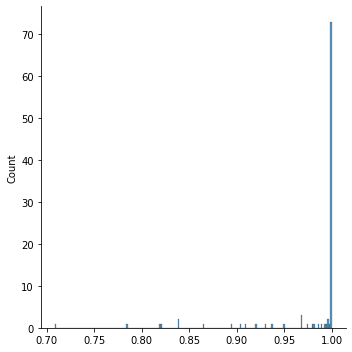

In [41]:
sns.displot(np.array(trace_4_2)[:, 2])